In [1]:
import numpy as np
import tensorflow as tf
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path

from collections import Counter
from tqdm import tqdm
from PIL import Image
import time

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [22]:
data_root = Path("../leo_segmentation/data/pascal_5i_fold_1/").resolve()

In [23]:
def load_pickled_data(data_path):
    """Reads a pickle file"""
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def save_pickled_data(data, data_path):
    """Saves a pickle file"""
    with open(data_path, "wb") as f:
        data = pickle.dump(data,f)
    return data

def load_npy(filename):
    """Reads a npy file"""
    filename = f"{filename}.npy" if len(os.path.splitext(filename)[-1]) == 0\
        else filename
    with open(filename, "rb") as f:
        return np.load(f)

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

## Load Dataset

In [24]:
class Transform_image(object):

    def __init__(self, img_height, img_width):
        self.img_width = img_width
        self.img_height = img_height

    def __call__(self, im):
        w, h = im.size
        if h > w:
            im = im.transpose(method=Image.ROTATE_270)
        
        im = im.resize((self.img_width, self.img_height))
        im = np.array(im)
        im = im.astype(np.float32)
        im = (im)/255.0
        return im
    

class Transform_mask(object):

    def __init__(self, img_height, img_width):
        self.img_width = img_width
        self.img_height = img_height

    def __call__(self, im):
        w, h = im.size

        if h > w:
            im = im.transpose(method=Image.ROTATE_270)

        im = im.resize((self.img_width, self.img_height), resample=0)
        im = np.array(im)/255
        im = (im[:, :, 0]).astype("int")
        return im

num_channels, img_height, img_width =  3, 384,512
image_transformer = Transform_image(img_height, img_width)
mask_transformer = Transform_mask(96, 128)

In [25]:
class SampleOneClass:
    """
    CustomData dataset
    
    """
    
    def __init__(self, class_name, bs=32, train_test_split=0.75, shuffle=True):
        self.bs = bs
        self.class_name = class_name
        self.img_datasets = datasets.ImageFolder(root=os.path.join(data_root, "images"))
        self.transform_image = image_transformer
        self.transform_mask = mask_transformer
        self.img_paths = [i[0] for i in self.img_datasets.imgs if class_name in i[0]]
        self.shuffle = shuffle
        if shuffle:
            np.random.shuffle(self.img_paths)
        self.len_train = int(len(self.img_paths) * train_test_split)
        self.len_val = len(self.img_paths) - self.len_train
        self.train_img_paths = self.img_paths[:self.len_train]
        self.val_img_paths = self.img_paths[self.len_train:]
        self.train_mask_paths = [i.replace(".jpg", ".npy").replace("images", "masks") for i in self.train_img_paths]
        self.val_mask_paths = [i.replace(".jpg", ".npy").replace("images", "masks") for i in self.val_img_paths]
        self.train_file_names = [i.split(os.sep)[-1] for i in self.train_img_paths]
        self.val_file_names = [i.split(os.sep)[-1] for i in self.val_img_paths]
        self.mode = "train"
        self.class_counts = Counter([i[0].split(os.sep)[-2] for i in self.img_datasets.imgs])
        
    
    def __getitem__(self, idx):
        img_paths =  self.img_paths[idx]
        mask_paths = self.mask_paths[idx]
        return self._load_data(img_paths, mask_paths)
    
    
    def _load_data(self, img_paths, mask_paths):
        img_paths  = [img_paths] if type(img_paths) == str else img_paths
        mask_paths  = [mask_paths] if type(mask_paths) == str else mask_paths           
        images = np.array([self.transform_image(Image.open(i)) for i in img_paths])
        masks = np.array([self.transform_mask(Image.fromarray(load_npy(i))) for i in mask_paths])
        return images, masks

    
    def __iter__(self):
        self.idx = 0
        if self.shuffle:
            np.random.shuffle(self.train_img_paths)
            np.random.shuffle(self.val_img_paths)
        self.train_mask_paths = [i.replace(".jpg", ".npy").replace("images", "masks") for i in self.train_img_paths]
        self.val_mask_paths = [i.replace(".jpg", ".npy").replace("images", "masks") for i in self.val_img_paths]
        assert set(self.val_img_paths).intersection(set(self.train_img_paths)) == set(), "some imgs are both in train and val"
        return self
    
    def __next__(self):
        if self.mode == "train":
            img_paths = self.train_img_paths
            mask_paths = self.train_mask_paths    
        else:
            img_paths = self.val_img_paths
            mask_paths = self.val_mask_paths
        
        if self.bs > len(img_paths):
            self.bs = len(img_paths)
            print("batch size is greater than max len", len(img_paths))
            print("\n New batch size is ",self.bs)
            
        try:
            img_paths =  img_paths[self.idx*self.bs:(self.idx+1)*self.bs]
            mask_paths = mask_paths[self.idx*self.bs:(self.idx+1)*self.bs]
            if img_paths == [] or mask_paths == []:
                raise IndexError
            self.idx += 1
            images, masks = self._load_data(img_paths, mask_paths)   
        except IndexError:
            raise StopIteration 
        return images, masks
                  
    def __len__(self):
        return self.class_counts[self.class_name]

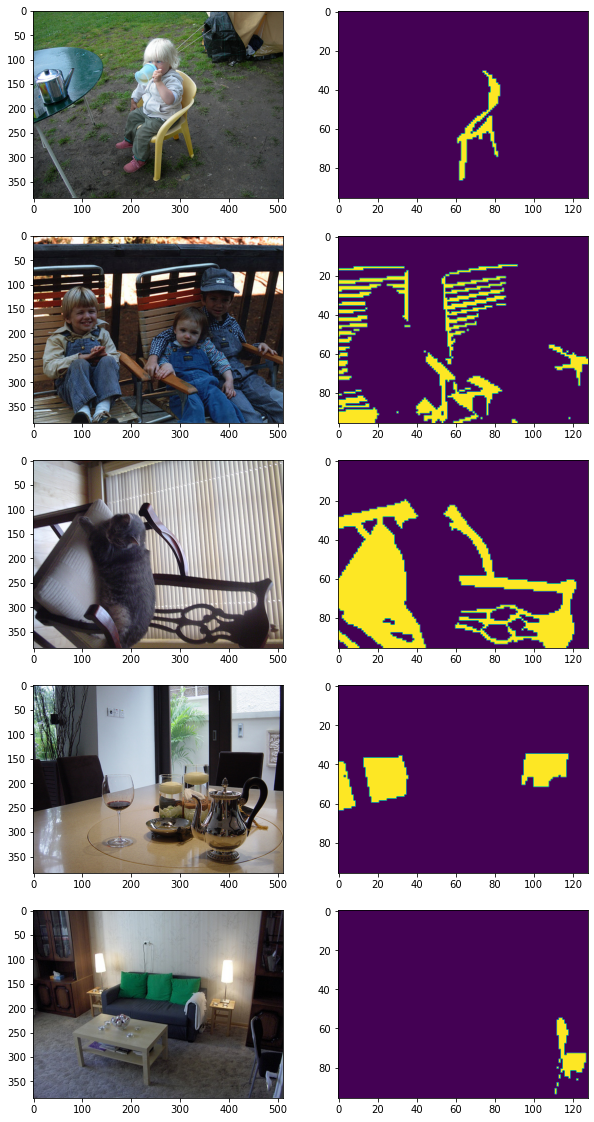

In [26]:
selected_class = "chair"
dataloader = SampleOneClass(selected_class, bs=3, shuffle=True)
dataloader.mode = "train"
fig = plt.figure(figsize=(10, 20))

for i, (img, mask) in enumerate(dataloader):
    fig.add_subplot(5,2,i*2+1)
    plt.imshow(img[0])
    
    fig.add_subplot(5,2,i*2+2)
    plt.imshow(mask[0])
    
    if i == 4:
        break

## Transfer Learning

In [7]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
resnet101_model = tf.keras.applications.ResNet101(
    weights="imagenet") 

In [9]:
resnet101_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [27]:
input_shape = (4, 56, 56, 3)
x = tf.random.normal(input_shape)
conv_layer = tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, dilation_rate=8, use_bias=False)
oup = conv_layer(x)

In [28]:
#with tpu_strategy.scope():
base_model = tf.keras.applications.ResNet101(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, num_channels), #375,500
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

layer_names = [
    #'conv2_block1_out',   # 256 channels, stride 4
    'conv2_block2_out',   # 256 channels, stride 4
    'conv2_block3_out',   # 256 channels, stride 4
    'conv4_block23_out',  # 1024 channels, stride 16
]

layers = [base_model.get_layer(name).output for name in layer_names]
# Freeze the base_model
encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)
encoder.trainable = False

inputs = tf.keras.Input(shape=((img_height, img_width, num_channels)))
# Downsampling through the model
skips = encoder(inputs, training=False)

conv1_1x1 = tf.keras.layers.Conv2D(filters=48, kernel_size=1, strides=1, padding='same', use_bias=False)
conv2_1x1 = tf.keras.layers.Conv2D(filters=48, kernel_size=1, strides=1, padding='same', use_bias=False)


conv1a = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False)
conv1a_bn = tf.keras.layers.BatchNormalization()

conv1b = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False)
conv1b_bn = tf.keras.layers.BatchNormalization()

conv2a = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=4, use_bias=False)
conv2a_bn = tf.keras.layers.BatchNormalization()

conv2b = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', dilation_rate=4, use_bias=False)
conv2b_bn = tf.keras.layers.BatchNormalization()

convfinal = tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding='same', dilation_rate=1, use_bias=False)

upsample = tf.keras.layers.UpSampling2D(size=4, interpolation='bilinear')
relu1 = tf.keras.layers.Activation("relu")
relu2 = tf.keras.layers.Activation("relu")
relu3 = tf.keras.layers.Activation("relu")
relu4 = tf.keras.layers.Activation("relu")
concat = tf.keras.layers.Concatenate()

#upsample1 = tf.keras.layers.Conv2DTranspose(8, 3, strides=2,padding='same')
encoder_output = skips[-1]

print(encoder_output.shape)
#comments on input size are wrong
x = upsample(encoder_output)
skip1 = conv1_1x1(skips[-2])
x = concat([x, skip1])
x = conv1a(x)
x = conv1a_bn(x)
x = relu1(x)
x = conv1b(x)
x = conv1b_bn(x)
x = relu2(x)
skip2 = conv1_1x1(skips[-3])
x = concat([x, skip2])
x = conv2a(x)
x = conv2a_bn(x)
x = relu3(x)
x = conv2b(x)
x = conv2b_bn(x)
x = relu4(x)
output = convfinal(x)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

(None, 24, 32, 1024)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 512, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 96, 128, 256 27659648    input_2[0][0]                    
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 96, 128, 1024 0           functional_1[0][2]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 48)  12288       functional_1[0][1]               
                                                                 f

In [29]:
def compute_loss(model, x, masks):
    logits = model(x)
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    scce_loss = scce(masks, logits)
    return scce_loss

def calc_iou_per_class(model, X, y, data_type):
    ious = []
    for i in range(len(X)):
        logit = model(np.expand_dims(X[i], 0))
        target = np.expand_dims(y[i], 0).astype(int)  
        pred = np.argmax(logit.numpy(),axis=-1).astype(int)
        iou = np.sum(np.logical_and(target, pred))/np.sum(np.logical_or(target, pred))
        ious.append(iou)
    return ious


def plot_prediction(model, imgs, masks):  
    fig = plt.figure(figsize=(30, 30))
    imgs = np.expand_dims(imgs, 0) if imgs.ndim==3 else imgs
    masks = np.expand_dims(masks, 0) if masks.ndim==2 else masks
    pred_masks = model(imgs).numpy()
    pred_masks = np.argmax(pred_masks, axis=-1)
    num_plots = len(imgs)
    for i in range(num_plots):
        fig.add_subplot(num_plots,3,i*3+1)
        plt.imshow((imgs[i]*255).astype("uint8"))

        fig.add_subplot(num_plots,3,i*3+2)
        plt.imshow(masks[i], cmap="gray")
        plt.title("ground truth")

        fig.add_subplot(num_plots,3,i*3+3)
        plt.imshow(pred_masks[i], cmap="gray")
        plt.title("predicted")
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

def plot_stats(stats, col):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(stats[col])
    plt.xlabel("epochs")
    plt.ylabel(col)
    plt.show()

@tf.function
def train_step(model, x, masks, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, masks)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

## Train

In [30]:
tf.keras.backend.clear_session()
selected_class = "aeroplane"
batch_size = 8
tr_val_split = 0.75
dataloader = SampleOneClass(selected_class, bs=batch_size, train_test_split=tr_val_split)
num_samples = len(dataloader)
epochs = 100
freq = 5
bs = 20
lr = 1e-3
training_stats = []
epoch_times = []
optimizer = tf.keras.optimizers.Adam(lr)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_batch_loss = []
    val_batch_loss = []
    dataloader.mode = "train"
    for imgs, masks in dataloader:
        batch_loss = train_step(model, imgs, masks, optimizer)
        train_batch_loss.append(batch_loss.numpy())
    
    dataloader.mode = "val"
    for imgs, masks in dataloader:
        batch_loss = compute_loss(model, imgs, masks)
        val_batch_loss.append(batch_loss.numpy())

    train_loss = float(np.mean(train_batch_loss))
    val_loss = float(np.mean(val_batch_loss))
        
    train_ious = []
    val_ious = []
    dataloader.mode = "train"
    for imgs, masks in dataloader:
        train_ious.extend(calc_iou_per_class(model, imgs, masks, "train"))
      
    dataloader.mode = "val"
    for imgs, masks in dataloader:
        val_ious.extend(calc_iou_per_class(model, imgs, masks, "train"))
    
    train_iou = np.mean(train_ious)
    val_iou = np.mean(val_ious)
    
    end_time = time.time()
    epoch_time = (end_time - start_time)/60
    
    if epoch % freq == 0:
        print(f"Epoch:{epoch:03d}- Epoch Time:{epoch_time:3f} train loss:{train_loss:3f}, val loss:{val_loss:3f}, train iou:{train_iou:3f}, val iou:{val_iou:3f}")
    epoch_times.append(epoch_time)
   
    training_stats.append({
      "epoch":epoch,
      "train loss":train_loss,
      "val loss":val_loss,
      "epoch time": epoch_time,
      "train_iou":train_iou,
      "val_iou":val_iou
    })
    
    if epoch % freq == 0:
        plot_prediction(model, imgs, masks)
        plot_stats(pd.DataFrame(training_stats), "train loss")
        plot_stats(pd.DataFrame(training_stats), "val loss")


ResourceExhaustedError:  OOM when allocating tensor with shape[8,1072,96,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_3/concatenate/concat (defined at <ipython-input-29-2a5089110328>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_44769]

Function call stack:
train_step


In [ ]:
plot_stats(pd.DataFrame(training_stats), "train loss")